In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#my classes
from dataset_loading import CocoLoader
import utils

#libs
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib import colormaps
import torchvision
import os
from torchmetrics.segmentation import MeanIoU

#sam
import sam_utils #sam_utils in the same directory
from segment_anything import SamPredictor, sam_model_registry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#CUDA tests
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #might not be viable, check again!

print("CUDA available:" + str(torch.cuda.is_available()))
from torch.utils.cpp_extension import CUDA_HOME
print("CUDA_HOME:" + str(CUDA_HOME))
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)
print(torch.cuda.device_count())

CUDA available:True
CUDA_HOME:/home.stud/svobo114/.conda/envs/detect_env_clone
1


In [13]:
coco=CocoLoader() 
transforms = None
data_train, api = coco.load_train(transformations=transforms)

loading annotations into memory...
Done (t=13.89s)
creating index...
index created!
loading annotations into memory...
Done (t=8.32s)
creating index...
index created!


## SAM testing. 
bulding pipeline without detection, using GT bboxes

In [60]:
predictor,sam = sam_utils.prepare_sam("cuda")

/home.stud/svobo114/.conda/envs/detect_env_clone/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t

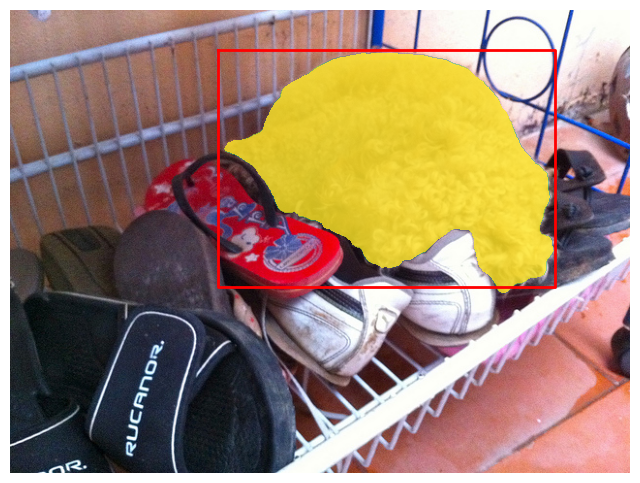

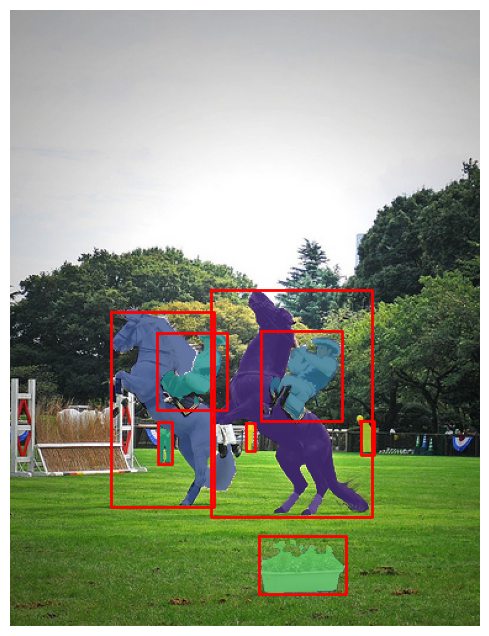

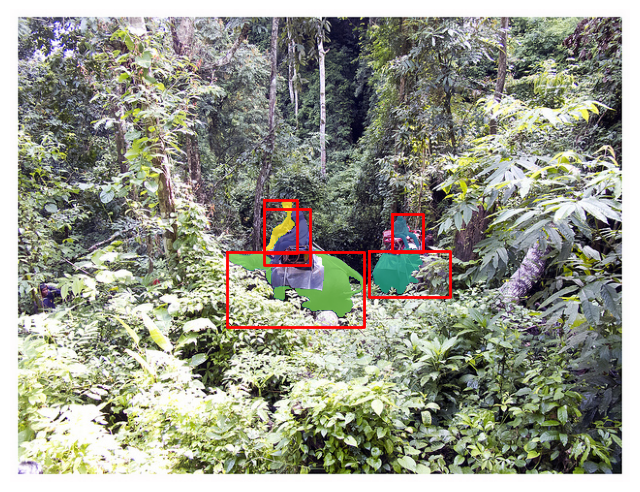

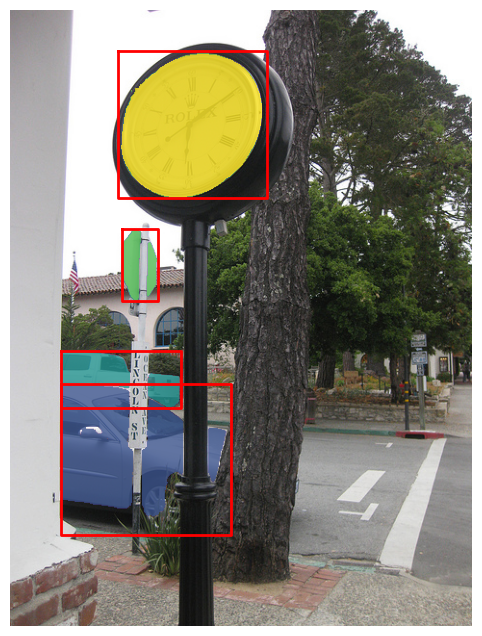

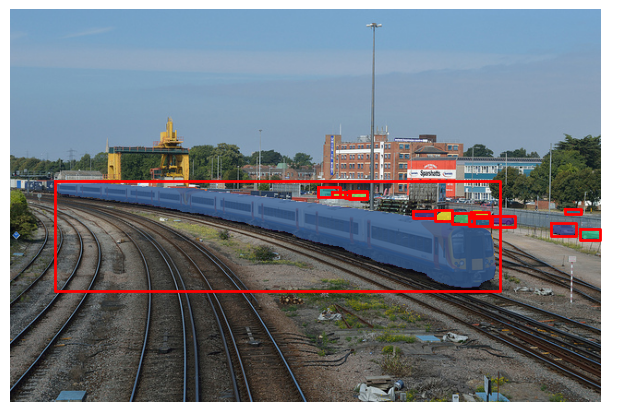

In [119]:
images_to_show=5
offset=5 #from the beginning of the dataset
scale=10
threshold=0.8 #threshold for the mask to be considered as "good"

MULTIMASK=False #output more masks for each box
MIDLLE_POINT=False #prompt with middl epoint as positive + box

''' 
load image, separate GT boxes and masks
TODO: detection module, currently using gt boxes
On the image, for each box: sam inference
Take best mask, if score>=threshold, add 
visualise successful masks in the boxes
'''
for i in range(images_to_show):
    pos=offset+i
    img = data_train[pos][0] #take po-th image, and leave the metadata
    metadata = data_train[pos][1]
    img=np.asarray(img)
    predictor.set_image(img) #sam

    gt_bboxes= utils.get_coco_boxes(metadata)
    gt_masks = utils.get_coco_masks(metadata,api) #for metrics, recall?

    #for GT boxes RN, else detection HERE!! TODO: detection module(s)
    detected_boxes = gt_bboxes 

    detected_masks=[] #mask for each box
    success=np.zeros(len(detected_boxes)) #1 if the mask was "good"

    for i,box in enumerate(detected_boxes): #prompt by box only
        prompt_coord=None
        prompt_label=None
        if MIDLLE_POINT: #imput middle as positive prompt
            prompt_coord=np.array([utils.get_middle_point(box)])
            prompt_label=np.array([1])
        
        masks, scores, logits = predictor.predict(
            point_coords=prompt_coord,
            point_labels=prompt_label,
            box=np.array(box),
            multimask_output=MULTIMASK, 
            )
        
        if  MULTIMASK: # filter masks, can do something different
            best_idx = np.argmax(scores)
            max_score= scores[best_idx]
            mask = masks[best_idx]
        else:
            mask=masks[0]
            max_score=scores[0]

        if max_score>=threshold:
            success[i]=1
            detected_masks.append(mask) #best mask?
            
    detected_masks=np.array(detected_masks)
    detected_boxes=np.array(detected_boxes)[success==1]

    sam_utils.print_masks_boxes(detected_masks,detected_boxes,img)

    
    #TODO: metrics??
        

    

In [ ]:
pos=7 
scale=10
selected_box=2
MIDLLE_POINT=True #prompt with middl epoint as positive + box




img = data_train[pos][0] #take pos-th image, and leave the metadata
metadata = data_train[pos][1]
img=np.asarray(img)
predictor.set_image(img) #sam

gt_bboxes= utils.get_coco_boxes(metadata)
gt_masks = utils.get_coco_masks(metadata,api) #for metrics, recall?

#for GT boxes RN, else detection HERE!! TODO: detection module(s)
detected_boxes = gt_bboxes 

detected_masks=[] #mask for each box
success=np.zeros(len(detected_boxes)) #1 if the mask was "good"


for i,box in enumerate(detected_boxes): #prompt by box only
    if selected_box!=i:
        continue

    #just box
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=np.array(box),
        multimask_output=MULTIMASK, 
        )
    print("Just the box as")
    print(scores)
    

    #with middle point as positive prompt
    prompt_coord=np.array([utils.get_middle_point(box)])
    prompt_label=np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=prompt_coord,
        point_labels=prompt_label,
        box=np.array(box),
        multimask_output=MULTIMASK, 
        )
    print("With middle point as prompt")
    print(scores)
    
    
    print(scores)
    if  MULTIMASK: # filter masks, can do something different
        best_idx = np.argmax(scores)
        max_score= scores[best_idx]
        mask = masks[best_idx]
    else:
        mask=masks[0]
        max_score=scores[0]

    if max_score>=threshold:
        success[i]=1
        detected_masks.append(mask) #best mask?
        
detected_masks=np.array(detected_masks)
detected_boxes=np.array(detected_boxes)[success==1]

sam_utils.print_masks_boxes(detected_masks,detected_boxes,img)

    

    